In [ ]:
from datetime import datetime, timedelta
from db import get_user_data  # Your function to query DB

user_profiles = {}

def is_outdated(user_profile):
    """Returns True if the profile is outdated (e.g., older than 1 min)."""
    return (datetime.now() - user_profile['updated_at']) > timedelta(minutes=1)

def compute_profile(df):
    """Compute the user's typical location/time profile."""
    profile = {
        "avg_lat": df['latitude'].mean(),
        "avg_lon": df['longitude'].mean(),
        "common_hours": df['hour'].mode().tolist(),
        "common_days": df['day'].mode().tolist()
    }
    return profile

def get_user_profile_cached(user_id):
    """Return the cached profile or recompute if missing/outdated."""
    if user_id not in user_profiles or is_outdated(user_profiles[user_id]):
        df = get_user_data(user_id)
        if df.empty:
            return None
        profile = compute_profile(df)
        user_profiles[user_id] = {
            "profile": profile,
            "updated_at": datetime.now()
        }
    return user_profiles[user_id]['profile']


from user_behavior import get_user_profile_cached
from geopy.distance import geodesic

def is_anomalous(lat, lon, timestamp, user_id):
    profile = get_user_profile_cached(user_id)
    if not profile:
        return False  # No data to compare against
    
    hour = timestamp.hour
    day = timestamp.weekday()
    
    # Time anomaly
    if hour not in profile['common_hours']:
        print("Unusual hour")

    # Location anomaly
    user_loc = (profile['avg_lat'], profile['avg_lon'])
    current_loc = (lat, lon)
    distance = geodesic(user_loc, current_loc).km
    if distance > 1.0:
        print("Unusual location")

    return (hour not in profile['common_hours']) or (distance > 1.0)

# Main scoring
risky_score, _, risky_type = predict_risk(lat, lon, method="dbscan")
is_behavior_anomaly = is_anomalous(lat, lon, timestamp, user_id)

# Simple fusion logic
final_score = risky_score
if is_behavior_anomaly:
    final_score += 0.3  # Boost if behavior looks weird


Location anomaly score: 0.00 (min distance: 0.01)
Time anomaly score: 1.00 (hour prob: 0.04, weekday prob: 0.04, month prob: 0.01)
Anomaly for user1 at (36.8065, 10.1815, 16:00, Weekday: 5, Month: 6): Location Anomaly: 0.00, Time Anomaly: 1.00
Location anomaly score: 1.00 (min distance: 2.92)
Time anomaly score: 1.00 (hour prob: 0.04, weekday prob: 0.04, month prob: 0.01)
Anomaly for user1 at (33.8815, 10.0982, 23:00, Weekday: 5, Month: 6): Location Anomaly: 1.00, Time Anomaly: 1.00
Location anomaly score: 0.00 (min distance: 0.01)
Time anomaly score: 0.70 (hour prob: 0.04, weekday prob: 0.44, month prob: 0.01)
Anomaly for user2 at (33.8815, 10.0982, 16:00, Weekday: 5, Month: 6): Location Anomaly: 0.00, Time Anomaly: 0.70
Location anomaly score: 1.00 (min distance: 2.92)
Time anomaly score: 0.70 (hour prob: 0.06, weekday prob: 0.44, month prob: 0.01)
Anomaly for user2 at (36.8065, 10.1815, 2:00, Weekday: 5, Month: 2): Location Anomaly: 1.00, Time Anomaly: 0.70
Insufficient data for use

C:\Users\user\AppData\Local\Temp\ipykernel_17620\2848124407.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2025-05-01', periods=n_points, freq='H'),


Location anomaly score: 0.00 (min distance: 0.01)
Time anomaly score: 1.00 (hour prob: 0.04, weekday prob: 0.48, month prob: 0.01)
Anomaly for user3 at (35.6754, 10.1033, 3:00, Weekday: 4, Month: 2): Location Anomaly: 0.00, Time Anomaly: 1.00


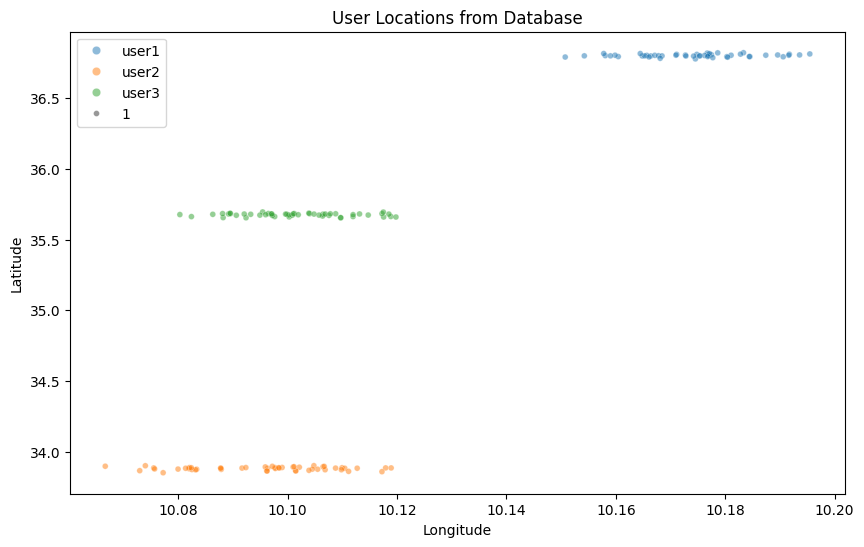

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuration
current_date = datetime(2025, 6, 28, 16, 13)  # 4:13 PM CET, Saturday, June 28, 2025
distance_threshold = 0.05  # ~5.5 km for unusual location
prob_threshold = 0.04  # 5% probability for unusual time
late_night_hours = list(range(22, 24)) + list(range(0, 5))  # 10 PM - 5 AM
min_data_points = 10  # Minimum data points for reliable user profile
db_path = 'user_data.db'

# Generate synthetic user data (fallback)
def generate_synthetic_data(user_id, n_points=50):
    # Generate synthetic data for a single user
    if user_id == 'user1':
        lat = np.random.normal(36.8065, 0.01, n_points // 2)  # Tunis (home)
        lon = np.random.normal(10.1815, 0.01, n_points // 2)
        lat = np.concatenate([lat, np.random.normal(36.8000, 0.01, n_points - n_points // 2)])  # Nearby (work)
        lon = np.concatenate([lon, np.random.normal(10.1700, 0.01, n_points - n_points // 2)])
    elif user_id == 'user2':
        lat = np.random.normal(33.8815, 0.01, n_points)  # Gabes
        lon = np.random.normal(10.0982, 0.01, n_points)
    else:
        lat = np.random.normal(35.6754, 0.01, n_points)  # Kairouan (default for new users)
        lon = np.random.normal(10.1033, 0.01, n_points)
    
    synthetic_data = pd.DataFrame({
        'user_id': [user_id] * n_points,
        'latitude': lat,
        'longitude': lon,
        'timestamp': pd.date_range(start='2025-05-01', periods=n_points, freq='h'),
    })
    synthetic_data['hour'] = synthetic_data['timestamp'].dt.hour
    synthetic_data['weekday'] = synthetic_data['timestamp'].dt.dayofweek
    synthetic_data['month'] = synthetic_data['timestamp'].dt.month
    return synthetic_data

# Database setup and data retrieval
def setup_database(data=None):
    conn = sqlite3.connect(db_path)
    if data is not None:
        data.to_sql('user_locations', conn, if_exists='replace', index=False)
    return conn

def load_user_data(user_id, conn):
    query = f"SELECT * FROM user_locations WHERE user_id = '{user_id}'"
    try:
        user_df = pd.read_sql(query, conn)
        return user_df
    except:
        return pd.DataFrame()

# Build user profile
def build_user_profile(user_id, conn, fallback_data=None):
    user_df = load_user_data(user_id, conn)
    
    # Fallback to synthetic data if insufficient
    if user_df.empty or len(user_df) < min_data_points:
        print(f"Insufficient data for {user_id} (found {len(user_df)} points). Using synthetic data.")
        if fallback_data is None:
            #user_df = generate_synthetic_data().query(f"user_id == '{user_id}'")
            user_df = generate_synthetic_data(user_id)
            if user_df.empty:
                user_df = generate_synthetic_data(n_points=50)  # Ensure some data
                user_df['user_id'] = user_id
        else:
            user_df = fallback_data.query(f"user_id == '{user_id}'")
        # Update database with synthetic data
        user_df.to_sql('user_locations', conn, if_exists='append', index=False)
    
    # Ensure timestamp is datetime
    user_df['timestamp'] = pd.to_datetime(user_df['timestamp'], errors='coerce')
    user_df['hour'] = user_df['timestamp'].dt.hour
    user_df['weekday'] = user_df['timestamp'].dt.dayofweek
    user_df['month'] = user_df['timestamp'].dt.month
    
    # Cluster user locations
    user_locations = user_df[['latitude', 'longitude']].values
    if len(user_locations) < 5:  # Minimum for clustering
        print(f"Not enough location points for {user_id} to cluster.")
        return None, None, None, None
    
    user_scaler = StandardScaler()
    user_locations_scaled = user_scaler.fit_transform(user_locations)
    user_optics = OPTICS(min_samples=5, xi=0.1, metric='euclidean')
    user_clusters = user_optics.fit_predict(user_locations_scaled)
    user_df['user_cluster'] = user_clusters
    
    # Frequent zones (centroids of non-noise clusters)
    frequent_zones = user_df[user_df['user_cluster'] != -1].groupby('user_cluster')[['latitude', 'longitude']].mean()
    
    # Usual activity times
    usual_hours = user_df['hour'].value_counts(normalize=True)
    usual_weekdays = user_df['weekday'].value_counts(normalize=True)
    usual_months = user_df['month'].value_counts(normalize=True)
    
    return frequent_zones, usual_hours, usual_weekdays, usual_months

# Detect anomalies
def detect_user_anomalies(lat, lon, hour, weekday, month, user_id, conn):
    frequent_zones, usual_hours, usual_weekdays, usual_months = build_user_profile(user_id, conn)
    
    if frequent_zones is None:
        print(f"No profile for {user_id}. Assuming no anomalies.")
        return 0.0, 0.0
    # Load the user data to compute historical distances
    user_df = load_user_data(user_id, conn)
    if not user_df.empty:
        historical_distances = np.sqrt(((user_df['latitude'] - lat) ** 2 + (user_df['longitude'] - lon) ** 2))
        distance_threshold = np.percentile(historical_distances, 95) if len(historical_distances) > 0 else 0.05
    else:
        distance_threshold = 0.05  # Default if no data
    
    # Unusual location
    location_anomaly = 0.0
    min_distance = np.inf
    if not frequent_zones.empty:
        for _, zone in frequent_zones.iterrows():
            distance = np.sqrt((lat - zone['latitude'])**2 + (lon - zone['longitude'])**2)
            min_distance = min(min_distance, distance)
        if min_distance > distance_threshold:
            location_anomaly = 1.0
    print(f"Location anomaly score: {location_anomaly:.2f} (min distance: {min_distance:.2f})")

    # Unusual time
    time_anomaly = 0.0
    hour_prob = usual_hours.get(hour, 0.01)
    weekday_prob = usual_weekdays.get(weekday, 0.01)
    month_prob = usual_months.get(month, 0.01)
    if hour_prob < prob_threshold:
        time_anomaly += 0.5
    if weekday_prob < prob_threshold:
        time_anomaly += 0.3
    if month_prob < prob_threshold:
        time_anomaly += 0.15
    if hour in late_night_hours:
        time_anomaly += 0.5
    time_anomaly = min(time_anomaly, 1.0)
    print(f"Time anomaly score: {time_anomaly:.2f} (hour prob: {hour_prob:.2f}, weekday prob: {weekday_prob:.2f}, month prob: {month_prob:.2f})")

    return location_anomaly, time_anomaly
# Main execution
if __name__ == "__main__":
    # Initialize database
    conn = setup_database()
    
    # Optional: Initialize with synthetic data if database is empty
    try:
        test_df = pd.read_sql("SELECT * FROM user_locations LIMIT 1", conn)
        if test_df.empty:
            #synthetic_data = generate_synthetic_data()
            synthetic_data = pd.concat([generate_synthetic_data('user1'), generate_synthetic_data('user2')])
            synthetic_data.to_sql('user_locations', conn, if_exists='append', index=False)
    except:
        synthetic_data = generate_synthetic_data()
        synthetic_data.to_sql('user_locations', conn, if_exists='append', index=False)
    
    # Test anomaly detection
    test_points = [
        ('user1', 36.8065, 10.1815, 16, 5, 6),  # User1, Tunis (home), 4 PM, Saturday, June
        ('user1', 33.8815, 10.0982, 23, 5, 6),  # User1, Gabes (unusual), 11 PM (unusual), Saturday, June
        ('user2', 33.8815, 10.0982, 16, 5, 6),  # User2, Gabes (home), 4 PM, Saturday, June
        ('user2', 36.8065, 10.1815, 2, 5, 2),   # User2, Tunis (unusual), 2 AM (unusual), February
        ('user3', 35.6754, 10.1033, 3, 4, 2)    # User3, Kairouan (no data), 3 AM, Friday, February
    ]
    
    for user_id, lat, lon, hour, weekday, month in test_points:
        loc_anomaly, time_anomaly = detect_user_anomalies(lat, lon, hour, weekday, month, user_id, conn)
        print(f"Anomaly for {user_id} at ({lat}, {lon}, {hour}:00, Weekday: {weekday}, Month: {month}): "
            f"Location Anomaly: {loc_anomaly:.2f}, Time Anomaly: {time_anomaly:.2f}")
    # Visualize user locations
    user_data = pd.read_sql("SELECT * FROM user_locations", conn)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=user_data, x='longitude', y='latitude', hue='user_id', size=1, alpha=0.5)
    plt.title('User Locations from Database')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()
    
    # Close database connection
    conn.close()

In [ ]:
def predict_risk_with_anomalies(lat, lon, hour, weekday, month, user_id, conn, model, scaler, cluster_weights, cluster_fatalities, cluster_event_types, cluster_temporal_density, X_scaled, low_risk_clusters, beta=2.0):
    loc_anomaly, time_anomaly = detect_user_anomalies(lat, lon, hour, weekday, month, user_id, conn)
    X_new = np.array([[lat, lon]], dtype=np.float32)
    X_new_scaled = scaler.transform(X_new)
    core_indices = np.where(model.core_distances_ != np.inf)[0]
    if len(core_indices) == 0:
        return 0.0, 0.0, 'None', loc_anomaly, time_anomaly
    core_points = X_scaled[core_indices]
    labels = model.labels_[core_indices]
    distances = np.sqrt(((X_new_scaled - core_points) ** 2).sum(axis=1))
    nearest_idx = np.argmin(distances)
    normalized_distance = distances[nearest_idx] / np.sqrt(((X_scaled - X_scaled.mean(axis=0)) ** 2).sum(axis=1)).max()
    nearest_cluster = labels[nearest_idx]
    event_type = cluster_event_types.get(nearest_cluster, 'Unknown')
    eps = np.percentile(model.core_distances_[core_indices], 95) if len(core_indices) > 0 else 0.05
    if distances[nearest_idx] <= eps:
        spatial_score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        spatial_score *= (1 + 0.2 * cluster_fatalities.get(nearest_cluster, 0) + 0.3 * cluster_temporal_density.get(nearest_cluster, 0))
        spatial_score /= (cluster_weights / cluster_weights.max() * (1 + 0.2 * cluster_fatalities + 0.3 * cluster_temporal_density)).max()
    else:
        base_score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        base_score *= (1 + 0.2 * cluster_fatalities.get(nearest_cluster, 0) + 0.3 * cluster_temporal_density.get(nearest_cluster, 0))
        spatial_score = max(base_score * np.exp(-beta * (distances[nearest_idx] - eps)), 0.2 * base_score)
        spatial_score /= (cluster_weights / cluster_weights.max() * (1 + 0.2 * cluster_fatalities + 0.3 * cluster_temporal_density)).max()
    if nearest_cluster in low_risk_clusters:
        loc_anomaly = 0.0
    combined_score = spatial_score * (1 + 0.5 * loc_anomaly + 0.5 * time_anomaly)
    combined_score = min(1.0, combined_score)
    return combined_score, normalized_distance, event_type, loc_anomaly, time_anomaly